# Example of TFRecords creation 

In [1]:
import os
import sys

import numpy as np

import tensorflow as tf

import argparse


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
# Load MNIST data into numpy arrays
(X_trn, y_trn), (X_tst, y_tst) = tf.keras.datasets.mnist.load_data()

X_trn = np.reshape(X_trn, [X_trn.shape[0], 28, 28, 1])
X_tst = np.reshape(X_tst, [X_tst.shape[0], 28, 28, 1])
print(X_trn.shape)
print(y_trn.shape)

(60000, 28, 28, 1)
(60000,)


In [3]:
def _int64_feature(values):
    if not isinstance(values, (tuple, list)):
        values = [values]
    return tf.train.Feature(int64_list=tf.train.Int64List(value=values))


def _bytes_feature(values):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[values]))


In [4]:
def convert_arrays_to_tfrecord(images, labels, output_file):
    """Converts a file to TFRecords."""
    print('Generating %s' % output_file)
    with tf.python_io.TFRecordWriter(output_file) as record_writer:
        for image, label in zip(images, labels):
            example = tf.train.Example(features=tf.train.Features(
                feature={
                        'image': _bytes_feature(image.tobytes()),
                        'label': _int64_feature(label)
                        }))
            record_writer.write(example.SerializeToString())
    print('Done!')
            

In [5]:
trn_tfrecords_file = '/tmp/trn.tfrecord'
convert_arrays_to_tfrecord(X_trn, y_trn, trn_tfrecords_file)

tst_tfrecords_file = '/tmp/tst.tfrecord'
convert_arrays_to_tfrecord(X_tst, y_tst, trn_tfrecords_file)


Generating /tmp/trn.tfrecord
Done!
Generating /tmp/trn.tfrecord
Done!


# Create the parser and the input_fn functions

In [6]:
DEPTH = 1
HEIGHT = 28
WIDTH = 28

def mnist_parser(serialized_example):
    """Parses a single tf.Example into image and label tensors."""
    features = tf.parse_single_example(
        serialized_example,
        features={
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64),
        })
    image = tf.decode_raw(features['image'], tf.uint8)
    image.set_shape([DEPTH * HEIGHT * WIDTH])

    # Reshape from [depth * height * width] to [depth, height, width].
    image = tf.cast(
        tf.transpose(tf.reshape(image, [DEPTH, HEIGHT, WIDTH]), [1, 2, 0]),
        tf.float32)
    label = tf.cast(features['label'], tf.int32)

    # Custom preprocessing.
    #image = self.preprocess(image)

    return image, label

In [7]:
def train_input_fn(TFfilenames, batch_size):
    """An input function for training"""
    
    dataset = tf.data.TFRecordDataset(TFfilenames)
    dataset = dataset.map(mnist_parser, num_parallel_calls=1)
    
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache().shuffle(buffer_size=1000).repeat().batch(batch_size)

    # Generate iterator and return the next elements of the iterator
    # in 1.6 and above you can pass directly the dataset and the estimator build internaly the iterator.
    (images, labels) = dataset.make_one_shot_iterator().get_next()
    return (images, labels)


In [8]:
def test_input_fn(TFfilenames, batch_size):
    # ... Pending
    return (images, labels)




In [9]:
# Define our input pipeline. Pin it to the CPU so that the GPU can be reserved
# for forward and backwards propogation.

tf.reset_default_graph()

batch_size = 32
with tf.device('/cpu:0'):
    train_images, train_labels = train_input_fn(trn_tfrecords_file, batch_size)
    
 

# Check the tfrecord content

[2 2 5 9 5 4 6 1 1 2 0 6 3 7 0 8 4 4 1 2 3 8 8 2 1 4 0 2 8 3 4 6]


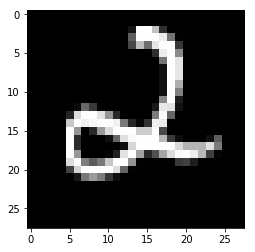

In [10]:
# Sanity check that all is correct
%matplotlib inline
import matplotlib.pyplot as plt

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    with tf.contrib.slim.queues.QueueRunners(sess):
        sample_images, sample_labels = sess.run([train_images, train_labels])

plt.imshow(sample_images[0,:,:,0], cmap='gray')
print(sample_labels)

# Use a default estimator

In [11]:
class Model(tf.keras.models.Model):
  """Model to recognize digits in the MNIST dataset.
  """

  def __init__(self):
        
    # Define layers to use in the model
    self._input_shape = [-1, 28, 28, 1]

    self.conv1 = tf.layers.Conv2D(32, 5, padding='same', activation=tf.nn.relu)
    self.max_pool2d = tf.layers.MaxPooling2D((2, 2), (2, 2), padding='same')
    
    self.conv2 = tf.layers.Conv2D(64, 5, padding='same', activation=tf.nn.relu)
    
    self.fc1 = tf.layers.Dense(1024, activation=tf.nn.relu)
    self.dropout = tf.layers.Dropout(0.4)
    
    self.fc2 = tf.layers.Dense(10)

    
  def __call__(self, inputs, training):
    """Add operations to classify a batch of input images.
    Args:
      inputs: A Tensor representing a batch of input images.
      training: A boolean. Set to True to add operations required only when
        training the classifier.
    Returns:
      A logits Tensor with shape [<batch_size>, 10].
    """
    y = tf.reshape(inputs, self._input_shape)
    y = self.conv1(y)
    y = self.max_pool2d(y)
    y = self.conv2(y)
    y = self.max_pool2d(y)
    y = tf.layers.flatten(y)
    y = self.fc1(y)
    y = self.dropout(y, training=training)
    return self.fc2(y)


In [12]:
# Define the model


# Define the model_function compatible with tf.estimators
def model_fn(features, labels, mode, params):
    """The model_fn argument for creating an Estimator."""
    image = features
    if isinstance(image, dict):
        image = features['image']
    
    # Instanciate the model
    model = Model()
    

    # Train step
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)

        logits = model(image, training=True)
    
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        accuracy = tf.metrics.accuracy(labels=labels, predictions=tf.argmax(logits, axis=1))
        tf.identity(accuracy[1], name='train_accuracy')
    
        tf.summary.scalar('train_accuracy', accuracy[1])
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.TRAIN,
            loss=loss,
            train_op=optimizer.minimize(loss, tf.train.get_or_create_global_step()))



    if mode == tf.estimator.ModeKeys.EVAL:
        logits = model(image, training=False)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.EVAL,
            loss=loss,
            eval_metric_ops={
                'accuracy':
                    tf.metrics.accuracy(
                        labels=labels,
                        predictions=tf.argmax(logits, axis=1)),
            })


    if mode == tf.estimator.ModeKeys.PREDICT:
        logits = model(image, training=False)
        predictions = {
            'classes': tf.argmax(logits, axis=1),
            'probabilities': tf.nn.softmax(logits),
        }
        return tf.estimator.EstimatorSpec(
            mode=tf.estimator.ModeKeys.PREDICT,
            predictions=predictions,
            export_outputs={
                'classify': tf.estimator.export.PredictOutput(predictions)
            })



In [13]:
def main(unused_argv):
    
    # Create classifier
    mnist_classifier = tf.estimator.Estimator(
          model_fn=model_fn,
          model_dir='/tmp/mnist',
          params={})

    # Set up training hook that logs the training accuracy every 100 steps.
    tensors_to_log = {'train_accuracy': 'train_accuracy'}
    logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=10)

    # Train the model
    mnist_classifier.train(input_fn=lambda:train_input_fn(trn_tfrecords_file, FLAGS.batch_size),
                           hooks=[logging_hook], max_steps=FLAGS.train_steps)

    
    # Evaluate the model and print results
    eval_results = mnist_classifier.evaluate(input_fn=lambda:train_input_fn(tst_tfrecords_file, FLAGS.batch_size))
    print()
    print('Evaluation results:\n\t%s' % eval_results)

    # Export the model
    image = tf.placeholder(tf.float32, [None, 28, 28, 1])
    input_fn = tf.estimator.export.build_raw_serving_input_receiver_fn({'image': image})
    mnist_classifier.export_savedmodel('/tmp/mnist_model/', input_fn)
    
#tf.estimator.Estimator.export_savedmodel()    
    

if __name__ == '__main__':
    
    # Define the arguments of the program
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', default=32, type=int, help='batch size')
    parser.add_argument('--train_steps', default=1000, type=int,
                        help='number of training steps')

    tf.logging.set_verbosity(tf.logging.INFO)
    FLAGS, unparsed = parser.parse_known_args()
    
    tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc51817c400>, '_task_id': 0, '_save_summary_steps': 100, '_service': None, '_tf_random_seed': None, '_log_step_count_steps': 100, '_model_dir': '/tmp/mnist', '_is_chief': True, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_task_type': 'worker'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /tmp/mnist/model.ckpt-100
INFO:tensorflow:Saving checkpoints for 101 into /tmp/mnist/model.ckpt.
INFO:tensorflow:train_accuracy = 0.84375
INFO:tensorflow:loss = 1.00334, step = 101
INFO:tensorflow:train_accuracy = 0.84375 (0.198 sec)
INFO:tensorflow:train_accuracy = 0.875 (0.059 sec)
INFO:tensorflow:train_accuracy = 0.851562 (0.061 sec)
IN

KeyboardInterrupt: 